In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gc
from tqdm.notebook import tqdm
from collections import deque

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, GPT2LMHeadModel, set_seed

from src.config import Config
from src.dataset2 import SBICDataset

CONFIG:Config = Config()
set_seed(CONFIG.seed)

/Users/matteoperiani/miniconda3/envs/nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_pickle(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,offensiveYN,speakerMinorityYN,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
1,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
2,0.0,0.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
3,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2', padding_side="left")
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

tokenizer.add_special_tokens(CONFIG.train_params.special_tokens)
print("List of all special token and its token_id:")
print(" -", tokenizer.all_special_tokens)
print(" -",tokenizer(tokenizer.all_special_tokens)["input_ids"])
print("Model vocab size pre resize:", model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))
print("Model vocab size post resize:", model.config.vocab_size)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.sep_token_id = tokenizer.sep_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
print("Model pad token:", model.config.pad_token_id)
print("Model sep token:", model.config.sep_token_id)

model.generation_config.max_new_tokens=50

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50271. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


List of all special token and its token_id:
 - ['[STR]', '[END]', '<|endoftext|>', '[SEP]', '[PAD]', '[offY]', '[offN]', '[sexY]', '[sexN]', '[intY]', '[intN]', '[grpY]', '[grpN]', '[ingrpN]', '[ingrpY]']
 - [[50257], [50258], [50256], [50260], [50259], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268], [50269], [50270]]
Model vocab size pre resize: 50257
Model vocab size post resize: 50271
Model pad token: 50259
Model sep token: 50260


In [5]:
train_data = pd.read_pickle(CONFIG.dataset.train_data_raw).to_numpy()[4:5]
# val_data = pd.read_pickle(CONFIG.dataset.val_data_raw).to_numpy()[:100]

train_dataset = SBICDataset(train_data, tokenizer, max_sequence_length=256)
# val_dataset = SBICDataset(val_data, tokenizer, CONFIG.utils.class_label_encoder)

train_loader = DataLoader(train_dataset, batch_size=1, drop_last=False, shuffle=True, pin_memory=True)
# val_loader   = DataLoader(val_dataset,   batch_size=CONFIG.train_params.batch_size, drop_last=False, shuffle=True, pin_memory=True)

In [6]:
# model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(CONFIG.train_params.device)

optimizer = AdamW(model.parameters(), lr=1e-4)

total_loss = 0
loss_epochs = deque(maxlen=40)

for epoch in range(40):
    model.train()
    epoch_train_loss = 0.0
    for n_iter, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # for n_iter, batch in enumerate(tqdm(train_loader, total=len(train_loader))):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        
        model.zero_grad()
            
        # Forward pass
        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        labels = inputs["labels"] )
        loss, logit = outputs[:2]

        total_loss += loss.item()

        if n_iter % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()} iteration n°{n_iter+1}")
        
        # Backward pass
        loss.backward()
        loss_epochs.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
                
        # gc.collect()

    avg_epoch_loss = total_loss / len(train_loader)

gc.collect
torch.cuda.empty_cache()

Epoch 0: loss = 2.6974570751190186 iteration n°1
Epoch 1: loss = 3.58070969581604 iteration n°1
Epoch 2: loss = 2.1185483932495117 iteration n°1
Epoch 3: loss = 4.631369590759277 iteration n°1
Epoch 4: loss = 2.2688944339752197 iteration n°1
Epoch 5: loss = 2.075911045074463 iteration n°1
Epoch 6: loss = 1.9325586557388306 iteration n°1
Epoch 7: loss = 1.038334608078003 iteration n°1
Epoch 8: loss = 1.3439741134643555 iteration n°1
Epoch 9: loss = 0.5002017617225647 iteration n°1
Epoch 10: loss = 1.3969908952713013 iteration n°1
Epoch 11: loss = 0.9687883257865906 iteration n°1
Epoch 12: loss = 1.0952033996582031 iteration n°1
Epoch 13: loss = 0.9150089621543884 iteration n°1
Epoch 14: loss = 1.1024599075317383 iteration n°1
Epoch 15: loss = 0.7421397566795349 iteration n°1
Epoch 16: loss = 0.6298480033874512 iteration n°1
Epoch 17: loss = 0.584059476852417 iteration n°1
Epoch 18: loss = 0.5422685742378235 iteration n°1
Epoch 19: loss = 0.4648604393005371 iteration n°1
Epoch 20: loss =

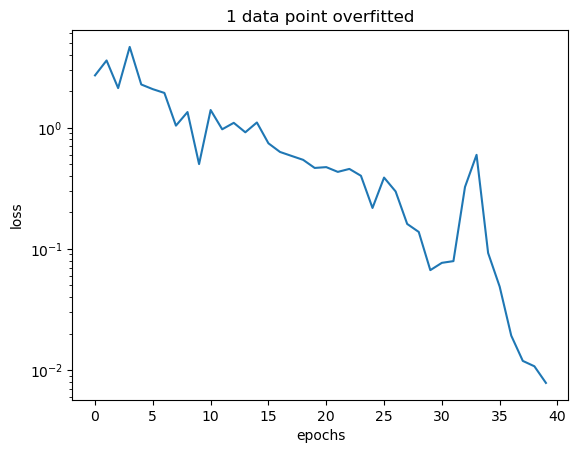

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(loss_epochs)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("1 data point overfitted")
plt.show()

In [8]:
model.eval()

post = train_data[0][5]
# inputs_str = tokenizer.bos_token + post + tokenizer.sep_token
inputs_str = post
next_token = ""
for i in range(3):
    inputs_str += next_token
    inputs = tokenizer(inputs_str, padding="max_length", max_length=256, return_tensors="pt")
    inputs = {k: v.to(CONFIG.train_params.device) for k, v in inputs.items()}

    outputs = model(**inputs)
        
    logits = outputs.logits[0, -1, :]
    next_token = tokenizer.decode(torch.argmax(logits, axis=-1))

    print(inputs_str, "->", next_token, "")

RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. -> [intN] 
RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[intN] -> [intN] 
RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[intN][intN] -> [intN] 


In [9]:
model.eval()

with torch.no_grad():
    for n_iter, batch in enumerate(train_loader):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        # text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=False).replace("[PAD]", "")

        outputs = model.generate(inputs["input_ids"], max_new_tokens=10)

        decoded_output = tokenizer.decode(outputs.cpu().numpy()[0], skip_special_tokens=False)
        decoded_output = decoded_output.replace("[PAD]", "")
        print(decoded_output)

/Users/matteoperiani/miniconda3/envs/nlp/lib/python3.11/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot.[SEP][offY][offY][offY][offY][offY][offY][offY][offY][offY][offY]
